# `causalml` - Meta-Learner Example Notebook
This notebook only contains regression examples.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
import warnings

# from causalml.inference.meta import XGBTLearner, MLPTLearner
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.meta import LRSRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# imports from package
import logging
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from copy import deepcopy

logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

%matplotlib inline

/Users/jeong/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Single Treatment Case

### Generate synthetic data

In [3]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array(['treatment_a' if val==1 else 'control' for val in treatment])

## S-Learner

### ATE

In [4]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6622
INFO:causalml:    RMSE (Treatment):     0.6941
INFO:causalml:   sMAPE   (Control):     0.6536
INFO:causalml:   sMAPE (Treatment):     0.3721
INFO:causalml:    Gini   (Control):     0.8248
INFO:causalml:    Gini (Treatment):     0.8156


In [5]:
ate_s

array([0.57431368])

### ATE w/ Confidence Intervals

In [6]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6622
INFO:causalml:    RMSE (Treatment):     0.6941
INFO:causalml:   sMAPE   (Control):     0.6536
INFO:causalml:   sMAPE (Treatment):     0.3721
INFO:causalml:    Gini   (Control):     0.8248
INFO:causalml:    Gini (Treatment):     0.8156


In [7]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.54689052],
       [0.57431368],
       [0.60173684]])

### ATE w/ Boostrap Confidence Intervals

In [8]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6622
INFO:causalml:    RMSE (Treatment):     0.6941
INFO:causalml:   sMAPE   (Control):     0.6536
INFO:causalml:   sMAPE (Treatment):     0.3721
INFO:causalml:    Gini   (Control):     0.8248
INFO:causalml:    Gini (Treatment):     0.8156
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


In [9]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.51141982],
       [0.57431368],
       [0.64097547]])

### CATE

In [10]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6622
INFO:causalml:    RMSE (Treatment):     0.6941
INFO:causalml:   sMAPE   (Control):     0.6536
INFO:causalml:   sMAPE (Treatment):     0.3721
INFO:causalml:    Gini   (Control):     0.8248
INFO:causalml:    Gini (Treatment):     0.8156


In [11]:
cate_s

array([[0.37674308],
       [0.42519259],
       [0.60864675],
       ...,
       [0.19940662],
       [0.35013032],
       [0.78372002]])

### CATE w/ Confidence Intervals

In [12]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6622
INFO:causalml:    RMSE (Treatment):     0.6941
INFO:causalml:   sMAPE   (Control):     0.6536
INFO:causalml:   sMAPE (Treatment):     0.3721
INFO:causalml:    Gini   (Control):     0.8248
INFO:causalml:    Gini (Treatment):     0.8156
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


In [13]:
cate_s

array([[0.37674308],
       [0.42519259],
       [0.60864675],
       ...,
       [0.19940662],
       [0.35013032],
       [0.78372002]])

In [14]:
cate_s_lb

array([[-0.18972662],
       [ 0.20548496],
       [ 0.09983036],
       ...,
       [-0.62837307],
       [-0.19766161],
       [-0.07736247]])

In [15]:
cate_s_ub

array([[0.8139405 ],
       [1.278447  ],
       [1.21720439],
       ...,
       [0.90244564],
       [0.9450083 ],
       [1.1529291 ]])

## T-Learner

### ATE w/ Confidence Intervals

In [16]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988


In [17]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.55534845],
       [0.58090983],
       [0.60647121]])

### ATE w/ Boostrap Confidence Intervals

In [18]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [19]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.51343277],
       [0.58090983],
       [0.65843097]])

### CATE

In [20]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988


In [21]:
cate_t

array([[ 0.23669004],
       [-0.0793891 ],
       [-0.10774326],
       ...,
       [ 0.30539629],
       [ 0.50784194],
       [ 0.00356007]])

### CATE w/ Confidence Intervals

In [22]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [23]:
cate_t

array([[ 0.23669004],
       [-0.0793891 ],
       [-0.10774326],
       ...,
       [ 0.30539629],
       [ 0.50784194],
       [ 0.00356007]])

In [24]:
cate_t_lb

array([[-0.6752711 ],
       [-0.72038152],
       [-1.2330182 ],
       ...,
       [-0.82131582],
       [-0.48846376],
       [-0.39046848]])

In [25]:
cate_t_ub

array([[1.66480025],
       [1.60697527],
       [2.06829221],
       ...,
       [1.64941401],
       [1.59083122],
       [1.53139764]])

## X-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [26]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988


In [27]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.51454586],
       [0.53721713],
       [0.55988839]])

#### Without Propensity Score input

In [28]:
ate_x_no_p, ate_x_lb_no_p, ate_x_ub_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988


In [29]:
np.vstack((ate_x_lb_no_p, ate_x_no_p, ate_x_ub_no_p))

array([[0.51334384],
       [0.53600211],
       [0.55866038]])

In [30]:
learner_x.propensity_model

{'treatment_a': {'all training': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                       class_weight=None,
                       cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
                       dual=False, fit_intercept=True, intercept_scaling=1.0,
                       l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                       max_iter=100, multi_class='auto', n_jobs=None,
                       penalty='elasticnet', random_state=None, refit=True,
                       scoring=None, solver='saga', tol=0.0001, verbose=0)}}

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [31]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


In [32]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.46262759],
       [0.53721713],
       [0.59662513]])

#### Without Propensity Score Input

In [33]:
ate_x_b_no_p, ate_x_lb_b_no_p, ate_x_ub_b_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [34]:
np.vstack((ate_x_lb_b_no_p, ate_x_b_no_p, ate_x_ub_b_no_p))

array([[0.44360865],
       [0.53598752],
       [0.59794413]])

### CATE

#### With Propensity Score Input

In [35]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988


In [36]:
cate_x

array([[0.05178452],
       [0.01907274],
       [0.79584839],
       ...,
       [0.18147876],
       [0.34742898],
       [0.23145415]])

#### Without Propensity Score Input

In [37]:
cate_x_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988


In [38]:
cate_x_no_p

array([[0.06426511],
       [0.0189166 ],
       [0.78233515],
       ...,
       [0.2237187 ],
       [0.29647103],
       [0.2359861 ]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [39]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


In [40]:
cate_x

array([[0.05178452],
       [0.01907274],
       [0.79584839],
       ...,
       [0.18147876],
       [0.34742898],
       [0.23145415]])

In [41]:
cate_x_lb

array([[-0.71763188],
       [-0.79487709],
       [-0.329782  ],
       ...,
       [-0.57672694],
       [-0.48450804],
       [-0.43157597]])

In [42]:
cate_x_ub

array([[1.40320321],
       [1.59906792],
       [1.59324502],
       ...,
       [1.07747513],
       [1.30836353],
       [1.18985624]])

#### Without Propensity Score Input

In [43]:
cate_x_no_p, cate_x_lb_no_p, cate_x_ub_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4868
INFO:causalml:    RMSE (Treatment):     0.5434
INFO:causalml:   sMAPE   (Control):     0.5230
INFO:causalml:   sMAPE (Treatment):     0.3114
INFO:causalml:    Gini   (Control):     0.9216
INFO:causalml:    Gini (Treatment):     0.8988
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


In [44]:
cate_x_no_p

array([[0.06430496],
       [0.01891659],
       [0.78209735],
       ...,
       [0.22376976],
       [0.29645377],
       [0.23597794]])

In [45]:
cate_x_lb_no_p

array([[-0.62013372],
       [-0.90236405],
       [-0.31043938],
       ...,
       [-0.54219561],
       [-0.2852425 ],
       [-0.37437315]])

In [46]:
cate_x_ub_no_p

array([[1.4199368 ],
       [1.45096372],
       [1.57656827],
       ...,
       [1.34583137],
       [1.37899369],
       [1.25074382]])

## R-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [47]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [48]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.55904178],
       [0.55951123],
       [0.55998069]])

#### Without Propensity Score Input

In [49]:
ate_r_no_p, ate_r_lb_no_p, ate_r_ub_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [50]:
np.vstack((ate_r_lb_no_p, ate_r_no_p, ate_r_ub_no_p))

array([[0.49307912],
       [0.49354918],
       [0.49401924]])

In [51]:
learner_r.propensity_model

{'treatment_a': {'all training': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                       class_weight=None,
                       cv=KFold(n_splits=5, random_state=None, shuffle=True),
                       dual=False, fit_intercept=True, intercept_scaling=1.0,
                       l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                       max_iter=100, multi_class='auto', n_jobs=None,
                       penalty='elasticnet', random_state=None, refit=True,
                       scoring=None, solver='saga', tol=0.0001, verbose=0)}}

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [52]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [53]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.37951505],
       [0.54612646],
       [0.53701368]])

#### Without Propensity Score Input

In [54]:
ate_r_b_no_p, ate_r_lb_b_no_p, ate_r_ub_b_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


In [55]:
np.vstack((ate_r_lb_b_no_p, ate_r_b_no_p, ate_r_ub_b_no_p))

array([[0.37126915],
       [0.50635052],
       [0.51400059]])

### CATE

#### With Propensity Score Input

In [56]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [57]:
cate_r

array([[ 1.57365084],
       [-0.63619554],
       [-0.05320793],
       ...,
       [ 0.56346375],
       [ 0.56288183],
       [ 0.87085617]])

#### Without Propensity Score Input

In [58]:
cate_r_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss


In [59]:
cate_r_no_p

array([[-0.19582933],
       [-0.29006499],
       [ 0.46513131],
       ...,
       [ 0.89712083],
       [ 0.81002617],
       [ 0.82598114]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [60]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [61]:
cate_r

array([[ 0.43967736],
       [-0.27467608],
       [-0.36704457],
       ...,
       [ 1.70213294],
       [ 0.53581667],
       [ 0.67119908]])

In [62]:
cate_r_lb

array([[-2.36270347],
       [-2.10110987],
       [-3.33190218],
       ...,
       [-2.25005704],
       [-2.08611215],
       [-1.89283199]])

In [63]:
cate_r_ub

array([[3.23361461],
       [4.39421365],
       [3.95620847],
       ...,
       [3.15905744],
       [3.23586204],
       [2.31788745]])

#### Without Propensity Score Input

In [64]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p, cate_r_lb_no_p, cate_r_ub_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


In [65]:
cate_r_no_p

array([[-0.14972556],
       [ 0.18446118],
       [ 0.23380044],
       ...,
       [ 0.55917108],
       [-0.16540062],
       [ 0.62050438]])

In [66]:
cate_r_lb_no_p

array([[-2.37674593],
       [-1.66803797],
       [-3.47868801],
       ...,
       [-1.95877534],
       [-2.32770172],
       [-1.68704787]])

In [67]:
cate_r_ub_no_p

array([[2.9130644 ],
       [3.99895564],
       [3.61212277],
       ...,
       [3.174209  ],
       [3.38644627],
       [2.62858756]])

# Visualize

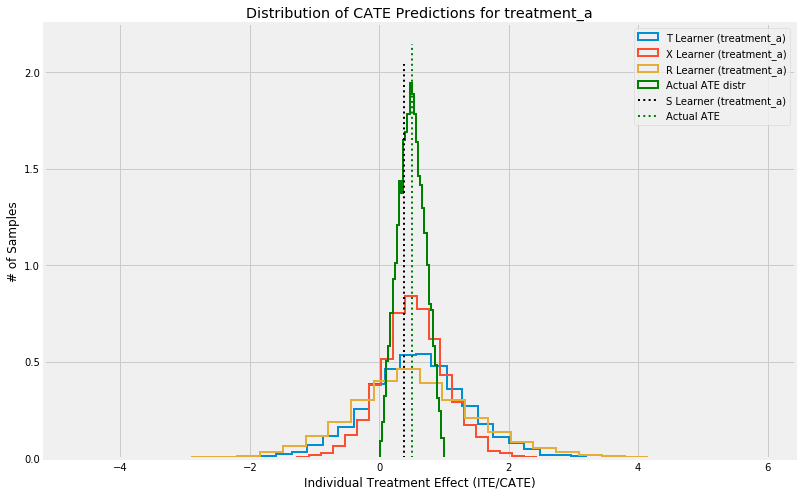

In [68]:
groups = learner_r._classes

alpha = 1
linewidth = 2
bins = 30
for group,idx in sorted(groups.items(), key=lambda x: x[1]):
    plt.figure(figsize=(12,8))
    plt.hist(cate_t[:,idx], alpha=alpha, bins=bins, label='T Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_x[:,idx], alpha=alpha, bins=bins, label='X Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(cate_r[:,idx], alpha=alpha, bins=bins, label='R Learner ({})'.format(group),
             histtype='step', linewidth=linewidth, density=True)
    plt.hist(tau, alpha=alpha, bins=bins, label='Actual ATE distr',
             histtype='step', linewidth=linewidth, color='green', density=True)
    plt.vlines(cate_s[0,idx], 0, plt.axes().get_ylim()[1], label='S Learner ({})'.format(group),
               linestyles='dotted', linewidth=linewidth)
    plt.vlines(tau.mean(), 0, plt.axes().get_ylim()[1], label='Actual ATE',
               linestyles='dotted', linewidth=linewidth, color='green')
    
    plt.title('Distribution of CATE Predictions for {}'.format(group))
    plt.xlabel('Individual Treatment Effect (ITE/CATE)')
    plt.ylabel('# of Samples')
    _=plt.legend()

---
# Multiple Treatment Case

### Generate synthetic data
Note: we randomize the assignment of treatment flag AFTER the synthetic data generation process, so it doesn't make sense to measure accuracy metrics here. Next steps would be to include multi-treatment in the DGP itself.

In [69]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

treatment = np.array([('treatment_a' if np.random.random() > 0.2 else 'treatment_b') 
                      if val==1 else 'control' for val in treatment])

e = {group: e for group in np.unique(treatment)}

In [70]:
pd.Series(treatment).value_counts()

control        4768
treatment_a    4146
treatment_b    1086
dtype: int64

## S-Learner

### ATE

In [71]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=False, bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6339
INFO:causalml:    RMSE (Treatment):     0.6447
INFO:causalml:   sMAPE   (Control):     0.6148
INFO:causalml:   sMAPE (Treatment):     0.3498
INFO:causalml:    Gini   (Control):     0.8528
INFO:causalml:    Gini (Treatment):     0.8492
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5584
INFO:causalml:    RMSE (Treatment):     0.4771
INFO:causalml:   sMAPE   (Control):     0.5699
INFO:causalml:   sMAPE (Treatment):     0.2768
INFO:causalml:    Gini   (Control):     0.8921
INFO:causalml:    Gini (Treatment):     0.9227


In [72]:
ate_s

array([0.58349553, 0.58778215])

In [73]:
learner_s._classes

{'treatment_a': 0, 'treatment_b': 1}

### ATE w/ Confidence Intervals

In [74]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
ate_s, ate_s_lb, ate_s_ub = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                   bootstrap_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6339
INFO:causalml:    RMSE (Treatment):     0.6447
INFO:causalml:   sMAPE   (Control):     0.6148
INFO:causalml:   sMAPE (Treatment):     0.3498
INFO:causalml:    Gini   (Control):     0.8528
INFO:causalml:    Gini (Treatment):     0.8492
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5584
INFO:causalml:    RMSE (Treatment):     0.4771
INFO:causalml:   sMAPE   (Control):     0.5699
INFO:causalml:   sMAPE (Treatment):     0.2768
INFO:causalml:    Gini   (Control):     0.8921
INFO:causalml:    Gini (Treatment):     0.9227


In [75]:
np.vstack((ate_s_lb, ate_s, ate_s_ub))

array([[0.5555693 , 0.55278018],
       [0.58349553, 0.58778215],
       [0.61142176, 0.62278413]])

### ATE w/ Boostrap Confidence Intervals

In [76]:
ate_s_b, ate_s_lb_b, ate_s_ub_b = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True,
                                                         bootstrap_ci=True, n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6339
INFO:causalml:    RMSE (Treatment):     0.6447
INFO:causalml:   sMAPE   (Control):     0.6148
INFO:causalml:   sMAPE (Treatment):     0.3498
INFO:causalml:    Gini   (Control):     0.8528
INFO:causalml:    Gini (Treatment):     0.8492
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5584
INFO:causalml:    RMSE (Treatment):     0.4771
INFO:causalml:   sMAPE   (Control):     0.5699
INFO:causalml:   sMAPE (Treatment):     0.2768
INFO:causalml:    Gini   (Control):     0.8921
INFO:causalml:    Gini (Treatment):     0.9227
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [77]:
np.vstack((ate_s_lb_b, ate_s_b, ate_s_ub_b))

array([[0.52550035, 0.52550035],
       [0.58349553, 0.58778215],
       [0.64944596, 0.64944596]])

### CATE

In [78]:
learner_s = BaseSRegressor(XGBRegressor(), control_name='control')
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6339
INFO:causalml:    RMSE (Treatment):     0.6447
INFO:causalml:   sMAPE   (Control):     0.6148
INFO:causalml:   sMAPE (Treatment):     0.3498
INFO:causalml:    Gini   (Control):     0.8528
INFO:causalml:    Gini (Treatment):     0.8492
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5584
INFO:causalml:    RMSE (Treatment):     0.4771
INFO:causalml:   sMAPE   (Control):     0.5699
INFO:causalml:   sMAPE (Treatment):     0.2768
INFO:causalml:    Gini   (Control):     0.8921
INFO:causalml:    Gini (Treatment):     0.9227


In [79]:
cate_s

array([[ 0.91381967,  0.82956386],
       [-0.17692167, -0.15709245],
       [ 0.90877771,  0.92332006],
       ...,
       [ 0.86159408,  0.53687155],
       [ 0.66541922,  0.78590739],
       [ 1.05691028,  1.03345728]])

### CATE w/ Confidence Intervals

In [80]:
alpha = 0.05
learner_s = BaseSRegressor(XGBRegressor(), ate_alpha=alpha, control_name='control')
cate_s, cate_s_lb, cate_s_ub = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                               n_bootstraps=100, bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.6339
INFO:causalml:    RMSE (Treatment):     0.6447
INFO:causalml:   sMAPE   (Control):     0.6148
INFO:causalml:   sMAPE (Treatment):     0.3498
INFO:causalml:    Gini   (Control):     0.8528
INFO:causalml:    Gini (Treatment):     0.8492
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.5584
INFO:causalml:    RMSE (Treatment):     0.4771
INFO:causalml:   sMAPE   (Control):     0.5699
INFO:causalml:   sMAPE (Treatment):     0.2768
INFO:causalml:    Gini   (Control):     0.8921
INFO:causalml:    Gini (Treatment):     0.9227
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


In [81]:
cate_s

array([[ 0.91381967,  0.82956386],
       [-0.17692167, -0.15709245],
       [ 0.90877771,  0.92332006],
       ...,
       [ 0.86159408,  0.53687155],
       [ 0.66541922,  0.78590739],
       [ 1.05691028,  1.03345728]])

In [82]:
cate_s_lb

array([[ 0.23816384, -0.32713253],
       [-0.44141183, -0.42676411],
       [-0.00206863, -0.43860602],
       ...,
       [ 0.29240462, -0.16563866],
       [-0.01797467, -0.10772878],
       [-0.51486325, -0.31691882]])

In [83]:
cate_s_ub

array([[1.40557503, 1.1807412 ],
       [1.06860972, 1.55298753],
       [1.38529261, 1.6596471 ],
       ...,
       [1.56729684, 1.47052228],
       [1.16166003, 1.1144281 ],
       [1.68127107, 1.58984778]])

## T-Learner

### ATE w/ Confidence Intervals

In [84]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
ate_t, ate_t_lb, ate_t_ub = learner_t.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984


In [85]:
np.vstack((ate_t_lb, ate_t, ate_t_ub))

array([[0.53107041, 0.5296616 ],
       [0.55739303, 0.55794811],
       [0.58371565, 0.58623463]])

### ATE w/ Boostrap Confidence Intervals

In [86]:
ate_t_b, ate_t_lb_b, ate_t_ub_b = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [87]:
np.vstack((ate_t_lb_b, ate_t_b, ate_t_ub_b))

array([[0.51777538, 0.51777538],
       [0.55739303, 0.55794811],
       [0.67471492, 0.67471492]])

### CATE

In [88]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984


In [89]:
cate_t

array([[ 1.47525787, -0.06651461],
       [ 1.26169336,  1.14718354],
       [ 1.68760026,  0.75878632],
       ...,
       [ 0.37292147,  0.20537615],
       [ 0.84290075,  0.80045319],
       [ 1.64227223,  1.91352534]])

### CATE w/ Confidence Intervals

In [90]:
learner_t = BaseTRegressor(XGBRegressor(), control_name='control')
cate_t, cate_t_lb, cate_t_ub = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100,
                                                    bootstrap_size=3000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


In [91]:
cate_t

array([[ 1.47525787, -0.06651461],
       [ 1.26169336,  1.14718354],
       [ 1.68760026,  0.75878632],
       ...,
       [ 0.37292147,  0.20537615],
       [ 0.84290075,  0.80045319],
       [ 1.64227223,  1.91352534]])

In [92]:
cate_t_lb

array([[-0.18706408, -0.84940575],
       [-1.01419897, -0.7311732 ],
       [-0.0427315 , -0.16378173],
       ...,
       [-0.39076423, -0.16869925],
       [-0.17401927, -0.19503389],
       [-0.61903974, -1.15808628]])

In [93]:
cate_t_ub

array([[2.47563672, 1.69891493],
       [2.04089584, 1.76605188],
       [2.3567108 , 2.40833322],
       ...,
       [2.17926003, 2.26919731],
       [2.15714553, 1.91076722],
       [2.27031788, 2.03901908]])

## X-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [94]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984


In [95]:
np.vstack((ate_x_lb, ate_x, ate_x_ub))

array([[0.49573269, 0.54002602],
       [0.51860246, 0.56163457],
       [0.54147223, 0.58324311]])

#### Without Propensity Score Input

In [96]:
ate_x_no_p, ate_x_lb_no_p, ate_x_ub_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984


In [97]:
np.vstack((ate_x_lb_no_p, ate_x_no_p, ate_x_ub_no_p))

array([[0.50418298, 0.56976992],
       [0.52706595, 0.59243233],
       [0.54994892, 0.61509475]])

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [98]:
ate_x_b, ate_x_lb_b, ate_x_ub_b = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


In [99]:
np.vstack((ate_x_lb_b, ate_x_b, ate_x_ub_b))

array([[0.49600789, 0.49600789],
       [0.51860246, 0.56163457],
       [0.63696386, 0.63696386]])

#### Without Propensity Score Input

In [100]:
ate_x_b_no_p, ate_x_lb_b_no_p, ate_x_ub_b_no_p = learner_x.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


In [101]:
np.vstack((ate_x_lb_b_no_p, ate_x_b_no_p, ate_x_ub_b_no_p))

array([[0.50100288, 0.50100288],
       [0.52706414, 0.59242806],
       [0.66020792, 0.66020792]])

### CATE

#### With Propensity Score Input

In [102]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984


In [103]:
cate_x

array([[ 0.57149441,  0.10240081],
       [-0.43192272,  1.48913118],
       [ 1.13622262,  0.65923928],
       ...,
       [ 0.44651704, -0.23119723],
       [ 0.93875551,  0.77003003],
       [ 0.96697381,  0.99990004]])

#### Without Propensity Score Input

In [104]:
cate_x_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984


In [105]:
cate_x_no_p

array([[ 0.62959351, -0.00493521],
       [-0.48863166,  1.54109948],
       [ 1.17988308,  1.26200671],
       ...,
       [ 0.41320951,  0.73251634],
       [ 0.91104634,  0.82359481],
       [ 1.08867931,  1.44193089]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [106]:
learner_x = BaseXRegressor(XGBRegressor(), control_name='control')
cate_x, cate_x_lb, cate_x_ub = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


In [107]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [108]:
cate_x

array([[ 0.57149441,  0.10240081],
       [-0.43192272,  1.48913118],
       [ 1.13622262,  0.65923928],
       ...,
       [ 0.44651704, -0.23119723],
       [ 0.93875551,  0.77003003],
       [ 0.96697381,  0.99990004]])

In [109]:
cate_x_lb

array([[-0.23574115, -0.21029023],
       [-0.95699419, -1.05203708],
       [-0.49402807, -0.48280283],
       ...,
       [-0.12162789, -0.26408791],
       [-0.52562958, -0.19338615],
       [-0.40858565, -0.88119588]])

In [110]:
cate_x_ub

array([[1.79950407, 2.11258332],
       [1.45309225, 1.48831446],
       [1.75564219, 2.03222137],
       ...,
       [2.15191078, 2.30032378],
       [1.65228261, 1.40411322],
       [1.74815254, 1.68257617]])

#### Without Propensity Score Input

In [111]:
cate_x_no_p, cate_x_lb_no_p, cate_x_ub_no_p = learner_x.fit_predict(X=X, treatment=treatment, y=y, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Error metrics for group treatment_a
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.4669
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.2675
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9297
INFO:causalml:Error metrics for group treatment_b
INFO:causalml:    RMSE   (Control):     0.4743
INFO:causalml:    RMSE (Treatment):     0.0747
INFO:causalml:   sMAPE   (Control):     0.5062
INFO:causalml:   sMAPE (Treatment):     0.0568
INFO:causalml:    Gini   (Control):     0.9280
INFO:causalml:    Gini (Treatment):     0.9984
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


In [112]:
learner_x._classes

{'treatment_a': 0, 'treatment_b': 1}

In [113]:
cate_x_no_p

array([[ 0.6294132 , -0.00492528],
       [-0.48876998,  1.54111376],
       [ 1.17989094,  1.2620318 ],
       ...,
       [ 0.41319463,  0.73237091],
       [ 0.9108665 ,  0.82359564],
       [ 1.08868219,  1.441931  ]])

In [114]:
cate_x_lb_no_p

array([[-0.10073893, -0.38800051],
       [-0.81971717, -0.8298923 ],
       [-0.18606629, -0.32586878],
       ...,
       [ 0.18372251, -0.12170252],
       [-0.21309623, -0.38600234],
       [-0.44863794, -0.39716903]])

In [115]:
cate_x_ub_no_p

array([[2.00312255, 2.10486085],
       [1.59355675, 1.76340695],
       [1.77980204, 2.35535097],
       ...,
       [1.94828429, 1.94720835],
       [2.04021647, 1.71337955],
       [1.60121219, 1.82820234]])

## R-Learner

### ATE w/ Confidence Intervals

#### With Propensity Score Input

In [116]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r, ate_r_lb, ate_r_ub = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [117]:
np.vstack((ate_r_lb, ate_r, ate_r_ub))

array([[0.52326968, 0.57744164],
       [0.52374892, 0.5781462 ],
       [0.52422816, 0.57885076]])

#### Without Propensity Score Input

In [118]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r_no_p, ate_r_lb_no_p, ate_r_ub_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [119]:
np.vstack((ate_r_lb_no_p, ate_r_no_p, ate_r_ub_no_p))

array([[0.44161159, 0.71836119],
       [0.44209269, 0.71904979],
       [0.44257378, 0.71973838]])

In [120]:
learner_r.propensity_model

{'treatment_a': {'all training': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                       class_weight=None,
                       cv=KFold(n_splits=5, random_state=None, shuffle=True),
                       dual=False, fit_intercept=True, intercept_scaling=1.0,
                       l1_ratios=array([0.001     , 0.33366667, 0.66633333, 0.999     ]),
                       max_iter=100, multi_class='auto', n_jobs=None,
                       penalty='elasticnet', random_state=None, refit=True,
                       scoring=None, solver='saga', tol=0.0001, verbose=0)},
 'treatment_b': {'all training': LogisticRegressionCV(Cs=array([1.00230524, 2.15608891, 4.63802765, 9.97700064]),
                       class_weight=None,
                       cv=KFold(n_splits=5, random_state=None, shuffle=True),
                       dual=False, fit_intercept=True, intercept_scaling=1.0,
                       l1_ratios=array([0.001     , 0.33366667,

### ATE w/ Boostrap Confidence Intervals

#### With Propensity Score Input

In [121]:
ate_r_b, ate_r_lb_b, ate_r_ub_b = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


In [122]:
np.vstack((ate_r_lb_b, ate_r_b, ate_r_ub_b))

array([[0.40326436, 0.40326436],
       [0.50620059, 0.5478152 ],
       [0.5697328 , 0.5697328 ]])

#### Without Propensity Score Input

In [123]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
ate_r_b_no_p, ate_r_lb_b_no_p, ate_r_ub_b_no_p = learner_r.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True,
                                                   n_bootstraps=100, bootstrap_size=5000)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals for ATE
100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


In [124]:
np.vstack((ate_r_lb_b_no_p, ate_r_b_no_p, ate_r_ub_b_no_p))

array([[0.45994051, 0.45994051],
       [0.44481491, 0.66323246],
       [0.68981572, 0.68981572]])

### CATE

#### With Propensity Score Input

In [125]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [126]:
cate_r

array([[ 5.57098567e-01,  1.77359581e-03],
       [ 1.08587885e+00,  2.48472750e-01],
       [ 3.34437251e-01,  1.69020355e+00],
       ...,
       [-9.96065974e-01, -8.98482800e-02],
       [ 1.70625651e+00,  9.55640435e-01],
       [-1.88456130e+00,  6.50659442e-01]])

#### Without Propensity Score Input

In [127]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y)

INFO:causalml:Generating propensity score
INFO:causalml:Calibrating propensity scores.
INFO:causalml:Calibrating propensity scores.
INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss


In [128]:
cate_r_no_p

array([[ 0.55478877,  0.87992519],
       [ 1.10120189,  1.29564619],
       [ 0.62448621,  0.41555083],
       ...,
       [-0.53886592,  0.44593787],
       [ 1.25231111,  0.79904991],
       [-0.64419305, -0.23014426]])

### CATE w/ Confidence Intervals

#### With Propensity Score Input

In [129]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r, cate_r_lb, cate_r_ub = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


In [130]:
cate_r

array([[ 1.75007784,  0.67752302],
       [ 0.77257723,  0.12910607],
       [ 1.08854032,  0.81679094],
       ...,
       [-0.92310214,  0.645491  ],
       [ 0.92478108,  0.79903334],
       [-0.48311949,  1.00291944]])

In [131]:
cate_r_lb

array([[-0.801657  , -0.48754777],
       [-3.05317249, -5.37572038],
       [-1.50823961, -1.16822439],
       ...,
       [-1.27909884, -1.2460175 ],
       [-1.42656819, -1.59059022],
       [-1.90115855, -2.10247456]])

In [132]:
cate_r_ub

array([[4.06750882, 3.68516954],
       [4.21587243, 4.50271177],
       [4.33370841, 3.79358828],
       ...,
       [3.53610538, 3.48638564],
       [3.71832166, 3.48292163],
       [5.01262635, 3.27047309]])

#### Without Propensity Score Input

In [ ]:
learner_r = BaseRRegressor(XGBRegressor(), control_name='control')
cate_r_no_p, cate_r_lb_no_p, cate_r_ub_no_p = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e, return_ci=True,
                                                     n_bootstraps=100, bootstrap_size=1000)

INFO:causalml:generating out-of-fold CV outcome estimates
INFO:causalml:training the treatment effect model for treatment_a with R-loss
INFO:causalml:training the treatment effect model for treatment_b with R-loss
INFO:causalml:Bootstrap Confidence Intervals
  2%|▏         | 2/100 [00:00<00:36,  2.69it/s]

In [ ]:
cate_r_no_p

In [ ]:
cate_r_lb_no_p

In [ ]:
cate_r_ub_no_p